# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
%pip install pyLDAvis==3.4.1
%pip install spacy
%python -m spacy download en_core_web_sm

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.2.6-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [2]:
# add any additional libaries you need here

import nltk

nltk.download("brown")

from nltk.corpus import brown

%pip install matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package brown to
[nltk_data]     /Users/bobbymarriott/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Note: you may need to restart the kernel to use updated packages.


In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
import pandas as pd

categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories:
    for file_id in brown.fileids(categories=category):
        # build some lists for a DataFrame
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id']       = file_ids
df['text']     = texts

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

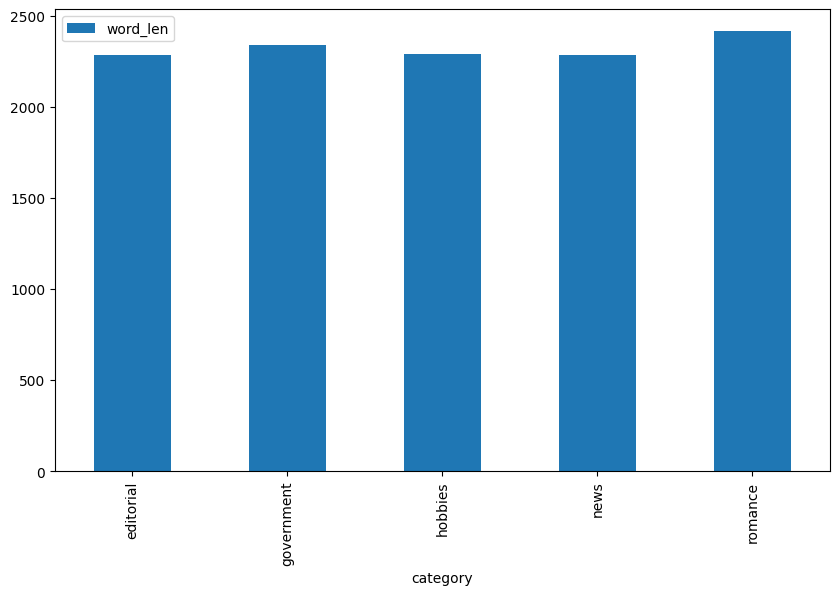

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/bobbymarriott/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: They contain raw token counts for each document, while text_vectorizer holds TF-IDF weights.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [12]:
df['topic'] = W_text_matrix.argmax(axis=1)

topic_category_counts = pd.crosstab(df['topic'], df['category'])
topic_category_counts

category,editorial,government,hobbies,news,romance
topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: NMF topics partially overlap with Brown categories. Topic 1 shows mostly "romance" while Topic 2 is almost split for "Government" and "Hobbies". Overall, the model seems to group simillar themes rather than match the original labels. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [13]:
from sklearn.decomposition import TruncatedSVD

# 1) Fit the LSA model
lsa_model = TruncatedSVD(n_components=5, random_state=314)
lsa_document_matrix = lsa_model.fit_transform(tfidf_text_vectors)

# 2) “top” topic
df['lsa_topic'] = lsa_document_matrix.argmax(axis=1)

# 3) LSA topic assignments against the original Brown categories
lsa_category_counts = pd.crosstab(df['lsa_topic'], df['category'])
print(lsa_category_counts)

feature_names = tfidf_text_vectorizer.get_feature_names_out()
for topic_idx, comp in enumerate(lsa_model.components_):
    top_indices = comp.argsort()[::-1][:5]
    top_words = [feature_names[i] for i in top_indices]
    print(f"\nLSA Topic {topic_idx}: {', '.join(top_words)}")

category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          30       36    34       21
1                  0           0        0     0        8
3                  0           0        0     3        0
4                  0           0        0     7        0

LSA Topic 0: said, mr, mrs, state, man

LSA Topic 1: said, ll, didn, thought, got

LSA Topic 2: mrs, mr, said, kennedy, khrushchev

LSA Topic 3: mrs, club, game, jr, university

LSA Topic 4: game, league, baseball, ball, team


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: They do not map to the original Brown Categories. Topic 0 spans nearly every category while Topic 1 alights with "romance". 

In [14]:
from sklearn.decomposition import TruncatedSVD

# 1) Instantiate and fit LSA model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa = lsa_text_model.fit_transform(tfidf_text_vectors)

display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Each topic's top words suggest it's theme. For example, Topic 00 is political with 'state', 'mr', mrs'. Topic 04 is about sports as the words are 'game', 'league', etc. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(
    n_components=5,
    learning_method="batch",
    max_iter=10,
    random_state=314
)
lda_topic_matrix = lda_model.fit_transform(count_text_vectors)

# (2) CountVectorizer’s vocabulary
feature_names = count_text_vectorizer.get_feature_names_out()

# (3) top 10 words
n_top = 10
for topic_idx, topic_coef in enumerate(lda_model.components_):
    top_indices = topic_coef.argsort()[::-1][:n_top]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Topic {topic_idx:02d}: {', '.join(top_words)}")

Topic 00: said, mrs, little, good, way, don, ll, old, man, thought
Topic 01: state, development, 000, program, business, system, sales, small, use, 1960
Topic 02: said, mr, president, city, state, american, john, week, home, world
Topic 03: feed, college, general, university, work, president, student, students, members, schools
Topic 04: states, state, united, shall, government, tax, fiscal, department, act, class


In [18]:
display_topics(lda_model, count_text_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)
  don (0.50)
  ll (0.47)
  old (0.44)
  man (0.43)
  thought (0.40)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)
  system (0.44)
  sales (0.40)
  small (0.39)
  use (0.37)
  1960 (0.37)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)
  american (0.37)
  john (0.36)
  week (0.35)
  home (0.35)
  world (0.35)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)
  president (0.36)
  student (0.36)
  students (0.34)
  members (0.33)
  schools (0.32)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)
  tax (0.57)
  fiscal (0.54)
  department (0.43)
  act (0.42)
  class (0.41)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: These LDA topics show coherent themes with Brown categories. 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The five-topic LDA assignments mirror the Brown Categories. One of the topics shows "news" and "government" texts while another has "hobbies and "romance" themes. There is no clear overlap, though. 

In [19]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

AttributeError: module 'pyLDAvis' has no attribute 'lda_model'

In [25]:
pyLDAvis.display(lda_display)

NameError: name 'lda_display' is not defined

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
